# [CS 4476 Problem Set 2: Local Feature Matching](https://faculty.cc.gatech.edu/~judy/cs4476-sp22/)

This Jupyter notebook:  
(1) Loads and resizes images  
(2) Finds interest points in those images                 (you code this)  
(3) Describes each interest point with a local feature    (you code this)  
(4) Finds matching features                               (you code this)  
(5) Visualizes the matches  
(6) Evaluates the matches based on ground truth correspondences  

## Setup

In [1]:
%matplotlib inline
%matplotlib notebook
%load_ext autoreload
%autoreload 2
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from utils import *
from student_feature_matching import match_features, pca, accelerated_matching
from student_sift import get_features
from student_harris import get_interest_points
from IPython.core.debugger import set_trace


from ps2_unit_tests.harris_unit_test import (
    test_get_gradients,
    test_get_gradients2,
    test_gaussian_kernel, 
    test_second_moment, 
    test_corner_response, 
    test_get_interest_points,
    test_find_single_valid_corner,
    verify
)
from ps2_unit_tests.sift_unit_test import (
    test_get_magnitudes_and_orientations,
    test_get_feat_vec,
    test_get_features, 
)

from ps2_unit_tests.feature_match_test import (
    test_compute_dists,
    test_feature_matching,
    test_pca
)



In [2]:
'''
Recommand start with Notre Dame image.
When you want to test out the other 2 images(Mount Rushmore,Episcopal Gaudi), you need to comment out the codes under Notre Dame and RERUN ALL cells below.
''' 

# Notre Dame
# image1 = load_image('../data/Notre Dame/921919841_a30df938f2_o.jpg')
# image2 = load_image('../data/Notre Dame/4191453057_c86028ce1f_o.jpg')
# eval_file = '../data/Notre Dame/921919841_a30df938f2_o_to_4191453057_c86028ce1f_o.pkl'

# # Mount Rushmore -- this pair is relatively easy (still harder than Notre Dame, though)
image1 = load_image('../data/Mount Rushmore/9021235130_7c2acd9554_o.jpg')
image2 = load_image('../data/Mount Rushmore/9318872612_a255c874fb_o.jpg')
eval_file = '../data/Mount Rushmore/9021235130_7c2acd9554_o_to_9318872612_a255c874fb_o.pkl'

# # Episcopal Gaudi -- This pair is relatively difficult
# image1 = load_image('../data/Episcopal Gaudi/4386465943_8cf9776378_o.jpg')
# image2 = load_image('../data/Episcopal Gaudi/3743214471_1b5bbfda98_o.jpg')
# eval_file = '../data/Episcopal Gaudi/4386465943_8cf9776378_o_to_3743214471_1b5bbfda98_o.pkl'

                    
scale_factor = 0.5
image1 = cv2.resize(image1, (0, 0), fx=scale_factor, fy=scale_factor)
image2 = cv2.resize(image2, (0, 0), fx=scale_factor, fy=scale_factor)
image1_bw = cv2.cvtColor(image1, cv2.COLOR_RGB2GRAY)
image2_bw = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY)

n_pts = 1500 # width and height of each local feature, in pixels. 

## Find distinctive points in each image (Szeliski 4.1.1)
### These are the results using the ground truth points

#### Note: Image may take some time to appear 

If you face 'the STRING opcode argument must be quoted' error, simply reopen the 'pkl' file for image loacted in data folder  in VScode. Chage the CRLF to LF at the bottome right corner of VScode.

<IPython.core.display.Javascript object>


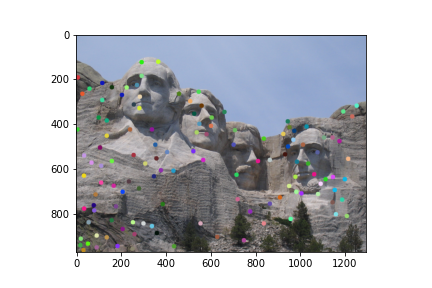

<IPython.core.display.Javascript object>


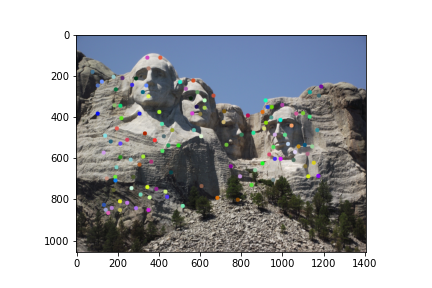

126 corners in image 1, 126 corners in image 2


In [3]:
x1, y1, x2, y2 = cheat_interest_points(eval_file, scale_factor)

# Visualize the interest points
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.figure(); plt.imshow(c1)
plt.figure(); plt.imshow(c2)
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

### This is where you implement and observe your results from `get_interest_points()`

#### First some unit tests

In [4]:
## Verify each step in the code, this will check if your implementation is correct or not.

## Do not modify the constructor of any function (i.e. to take some custom arguments as input)

print("Gaussian Kernel:", verify(test_gaussian_kernel))
print('Gradients test 1:', verify(test_get_gradients))
print('Gradients test 2:', verify(test_get_gradients2))
print('Second Moments:', verify(test_second_moment))
print('Corner Response:', verify(test_corner_response))

Gaussian Kernel: "Correct"
Gradients test 1: "Correct"
Gradients test 2: "Correct"
Second Moments: "Correct"
Corner Response: "Correct"


#### Now run it all together

R shape (972, 1296)
R_local_pts shape (972, 1296)
R shape (1056, 1408)
R_local_pts shape (1056, 1408)


<IPython.core.display.Javascript object>


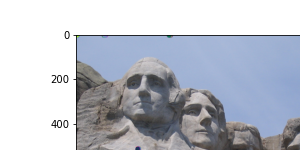

<IPython.core.display.Javascript object>


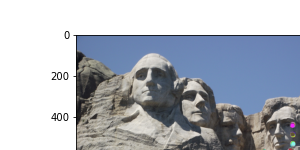

1500 corners in image 1, 1500 corners in image 2


In [5]:
x1, y1, R1, _= get_interest_points(image1_bw, n_pts)
x2, y2, R2, _= get_interest_points(image2_bw, n_pts)
c1 = show_interest_points(image1, x1, y1)
c2 = show_interest_points(image2, x2, y2)
plt.figure(); plt.imshow(c1)
plt.figure(); plt.imshow(c2)
print('{:d} corners in image 1, {:d} corners in image 2'.format(len(x1), len(x2)))

In [34]:
print('Interest Points:', verify(test_get_interest_points))
print('Interest Points Single Corner:', verify(test_find_single_valid_corner))

R shape (19, 19)
R_local_pts shape (19, 19)
Interest Points: "Correct"
R shape (25, 25)
R_local_pts shape (25, 25)
Interest Points Single Corner: "Wrong"


## Create feature vectors at each interest point (Szeliski 4.1.2)

#### This is where you will code the functions in `student_sift.py`. Run the following cell to test your implementation

In [ ]:
print("Magnitudes and Orientations:", verify(test_get_magnitudes_and_orientations))
print('Feature Vector', verify(test_get_feat_vec))
print('All Feature Vectors', verify(test_get_features))

#### Collect features from our image pair

In [ ]:
feature_width = 16
image1_features = get_features(image1_bw, x1, y1, feature_width)
image2_features = get_features(image2_bw, x2, y2, feature_width)

## Match features (Szeliski 4.1.3)

#### Complete `compute_feature_distances()` and `feature_matching()` in `student_feature_matching.py`. The following cell will test your implementations

In [ ]:
print("Feature Distances:", verify(test_compute_dists))
print('Matches:', verify(test_feature_matching))

#### Match features for our image pair

In [ ]:
start = time.time()
matches, confidences = match_features(image1_features, image2_features)
end = time.time()
unoptimized = end - start
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
print('Time Elapsed: {}'.format(unoptimized))

## Visualization

You might want to set 'num_pts_to_visualize' and 'num_pts_to_evaluate' to some constant (e.g. 100) once you start detecting hundreds of interest points, otherwise things might get too cluttered. You could also threshold based on confidence.  
  
There are two visualization functions below. **Note: For the report, use the visualization that shows correspondance lines (not circles)**

In [ ]:
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
os.makedirs('../results', exist_ok=True)
plt.savefig('../results/vis_circles.png', dpi=1000)

c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines.png', dpi=1000)

Comment out the function below if you are not testing on the Notre Dame, Episcopal Gaudi, and Mount Rushmore image pairs--this evaluation function will only work for those which have ground truth available.  
  
You can use `collect_ground_truth_corr.py` to build the ground truth for other image pairs if you want, but it's very tedious. It would be a great service to the class for future years, though!

In [ ]:
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval.png', dpi=1000)

## Bells and Whistles tests

### PCA

In [ ]:
print("PCA: ", verify(test_pca))

In [ ]:
n_components = 24
start = time.time()
reduced_image1_features, reduced_image2_features = pca(image1_features, image2_features, n_components)
matches, confidences = match_features(reduced_image1_features, reduced_image2_features)
end = time.time()
pca_optimized = end - start
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
print('Time Elapsed (PCA): {}'.format(pca_optimized))
print('Time Elapsed (no optimization): {}'.format(unoptimized))

**Note: For the report, use the visualization that shows correspondance lines (not circles)**

In [ ]:
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('../results/vis_circles_pca.png', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines_pca.png', dpi=1000)

In [ ]:
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval_pca.png', dpi=1000)

### Accelerated Matching

In [ ]:
start = time.time()
matches, confidences = accelerated_matching(image1_features, image2_features)
end = time.time()
accelerated = end - start
print('{:d} matches from {:d} corners'.format(len(matches), len(x1)))
print('Time Elapsed (Accelerated): {}'.format(accelerated))
print('Time Elapsed (PCA): {}'.format(pca_optimized))
print('Time Elapsed (no optimization): {}'.format(unoptimized))

**Note: For the report, use the visualization that shows correspondance lines (not circles)**

In [ ]:
# num_pts_to_visualize = len(matches)
num_pts_to_visualize = 100
c1 = show_correspondence_circles(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c1)
plt.savefig('../results/vis_circles_am.png', dpi=1000)
c2 = show_correspondence_lines(image1, image2,
                    x1[matches[:num_pts_to_visualize, 0]], y1[matches[:num_pts_to_visualize, 0]],
                    x2[matches[:num_pts_to_visualize, 1]], y2[matches[:num_pts_to_visualize, 1]])
plt.figure(); plt.imshow(c2)
plt.savefig('../results/vis_lines_am.png', dpi=1000)

In [ ]:
# num_pts_to_evaluate = len(matches)
num_pts_to_evaluate = 100
_, c = evaluate_correspondence(image1, image2, eval_file, scale_factor,
                        x1[matches[:num_pts_to_evaluate, 0]], y1[matches[:num_pts_to_evaluate, 0]],
                        x2[matches[:num_pts_to_evaluate, 1]], y2[matches[:num_pts_to_evaluate, 1]])
plt.figure(); plt.imshow(c)
plt.savefig('../results/eval_am.png', dpi=1000)